In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import xgboost as xgb

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "jupyterlab"

***
## loading data

In [2]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet("../ump-dataset/train.parquet", columns=features)
target = pd.read_parquet("../ump-dataset/train.parquet", columns=["target",])
time = pd.read_parquet("../ump-dataset/train.parquet", columns=["time_id",])

In [3]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [4]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.3
valid_size = int(valid_prop * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 363


In [5]:
valid_time_ids = time_ids[-valid_size:]

In [6]:
train_idx = time.query("time_id not in @valid_time_ids").index
valid_idx = time.query("time_id in @valid_time_ids").index

# dataframes for metric calculation
oof = target.loc[valid_idx,:].copy()
oof["time_id"] = time.loc[valid_idx,"time_id"]
features_valid = features.loc[valid_idx,:]

# input datasets for xgb
train_dset = xgb.DMatrix(
    data=features.loc[train_idx,:],
    label=target.loc[train_idx,"target"].values,
)
valid_dset = xgb.DMatrix(
    data=features.loc[valid_idx,:],
    label=target.loc[valid_idx,"target"].values,
)

In [7]:
import gc
gc.collect()

51

***
## Bayesian Optimization

In [8]:
default_params = {
    "tree_method":"hist",
    "grow_policy":"depthwise",
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'seed': 19,
    'verbosity': 0,
}

In [9]:
def pearsonr(preds: np.array, dset: xgb.DMatrix):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: DMatrix dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0]


In [10]:
def objective(trial):    
    sampled_params = dict(
        max_depth = trial.suggest_int("max_depth", 4, 10),
        max_bin = 2**trial.suggest_int("max_bin_exp", 5, 10),
        colsample_bytree = trial.suggest_discrete_uniform("colsample_bytree", 0.2, 1.0, 0.05),
        subsample = trial.suggest_discrete_uniform("subsample", 0.5, 1.0, 0.05),
        reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-3, 1e1),
        reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-3, 1e1),
        min_child_weight = trial.suggest_int("min_child_weight", 100, 1500, 100),
    )
    
    model_params = {**default_params, **sampled_params}    
    model = xgb.train(
        params=model_params,
        num_boost_round=trial.suggest_int("num_boost_round", 300, 1500, 100),
        dtrain=train_dset,
        evals=[(valid_dset,"valid"),],
        feval=pearsonr,
        maximize=True,
        verbose_eval=False,
    )
    
    # metric calculation
    _oof = oof.copy()
    _oof["pred"] = model.predict(valid_dset)
    corrs = _oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
    corr_mean = corrs.mean()
    corr_std = corrs.std()
    
    return corr_mean            

In [11]:
do_optimize = False

study = optuna.create_study(
    study_name="xgboost-gbrt",
    direction='maximize',
    storage='sqlite:///xgboost-gbrt.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=1000, 
        timeout=86400, # 24-hrs
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2022-02-23 17:05:19,267] Using an existing study with name 'xgboost-gbrt' instead of creating a new one.


In [12]:
study.trials_dataframe().sort_values("value", ascending=False).head(20)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_max_bin_exp,params_max_depth,params_min_child_weight,params_num_boost_round,params_reg_alpha,params_reg_lambda,params_subsample,state
131,131,0.131634,2022-02-23 14:52:42.142495,2022-02-23 15:15:47.840152,0 days 00:23:05.697657,0.20,9,8,1400,1400,3.353152,0.040000,0.95,COMPLETE
116,116,0.131145,2022-02-23 10:39:57.129810,2022-02-23 10:55:47.909506,0 days 00:15:50.779696,0.35,9,9,1400,900,4.454893,0.001012,0.90,COMPLETE
92,92,0.130998,2022-02-23 03:39:08.905105,2022-02-23 04:05:26.180565,0 days 00:26:17.275460,0.20,10,10,1400,1000,7.169759,0.027869,0.90,COMPLETE
85,85,0.130871,2022-02-23 02:05:15.670249,2022-02-23 02:16:11.094828,0 days 00:10:55.424579,0.20,9,9,1500,600,7.680050,0.006148,0.95,COMPLETE
128,128,0.130812,2022-02-23 14:08:29.286714,2022-02-23 14:21:14.921624,0 days 00:12:45.634910,0.20,9,9,1400,700,3.054165,0.001546,0.90,COMPLETE
108,108,0.130718,2022-02-23 08:29:06.357254,2022-02-23 08:43:20.809676,0 days 00:14:14.452422,0.35,9,9,1400,800,4.167469,0.001747,0.85,COMPLETE
37,37,0.130607,2022-02-22 09:28:31.383805,2022-02-22 09:49:12.526028,0 days 00:20:41.142223,0.20,8,7,1100,1300,3.954176,0.157590,1.00,COMPLETE
90,90,0.130556,2022-02-23 03:12:59.219420,2022-02-23 03:26:10.054351,0 days 00:13:10.834931,0.20,9,10,1500,700,3.730823,0.026221,0.90,COMPLETE
100,100,0.130478,2022-02-23 06:20:45.552908,2022-02-23 06:35:20.317484,0 days 00:14:34.764576,0.30,9,9,1300,800,5.005531,0.001268,0.90,COMPLETE
14,14,0.130456,2022-02-22 00:59:10.844791,2022-02-22 01:23:53.731172,0 days 00:24:42.886381,0.20,8,8,800,1500,6.991496,0.026506,1.00,COMPLETE


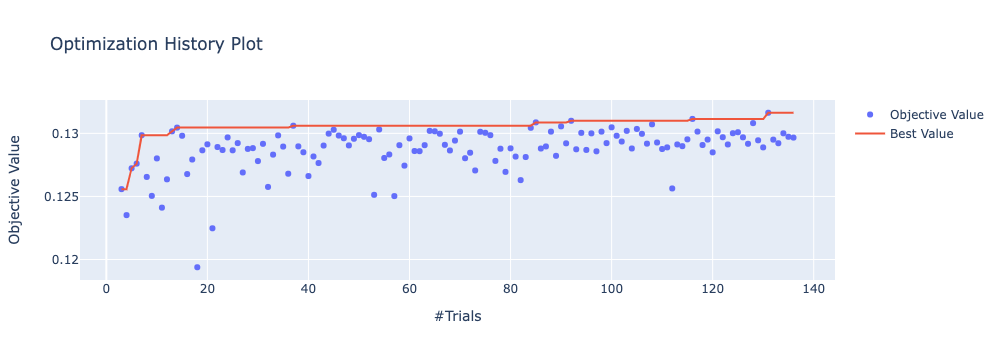

In [13]:
plot_optimization_history(study)

In [14]:
try:
    plot_param_importances(study)
except:
    pass

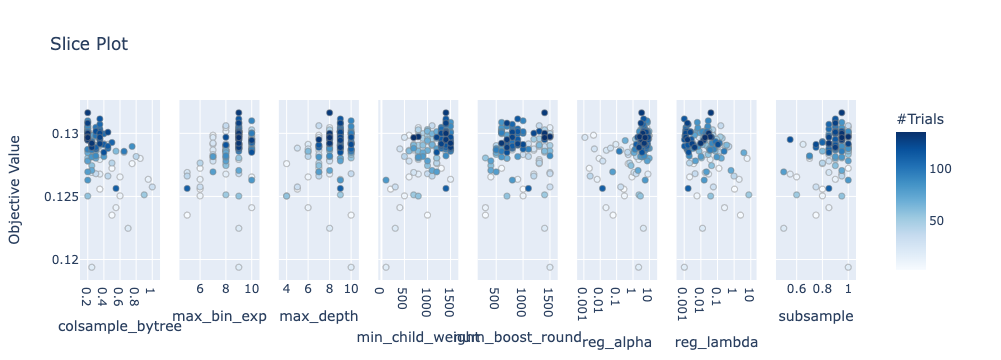

In [15]:
plot_slice(study)

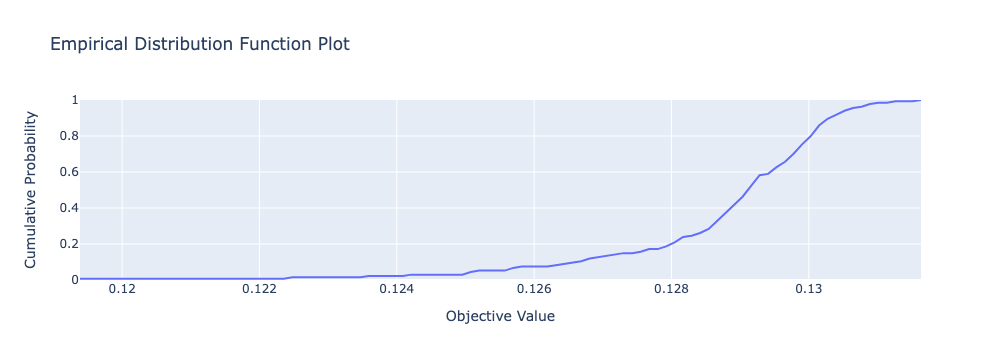

In [16]:
plot_edf(study)

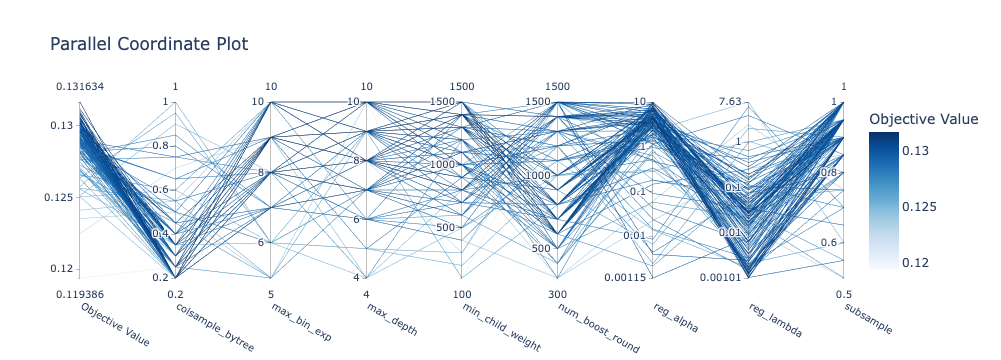

In [17]:
plot_parallel_coordinate(study)

In [18]:
best_params = dict(study.best_params)
best_params["max_bin"] = 2**best_params.pop("max_bin_exp")
best_params = {**default_params, **best_params}
best_params

{'tree_method': 'hist',
 'grow_policy': 'depthwise',
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'eta': 0.05,
 'seed': 19,
 'verbosity': 0,
 'colsample_bytree': 0.2,
 'max_depth': 8,
 'min_child_weight': 1400,
 'num_boost_round': 1400,
 'reg_alpha': 3.353151934210454,
 'reg_lambda': 0.039999836659986764,
 'subsample': 0.95,
 'max_bin': 512}

***